In [141]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from prince import MCA  # Multiple Correspondence Analysis for categorical data
from kmodes.kprototypes import KPrototypes  # Best for mixed data clustering
from sklearn.metrics import silhouette_score
from tqdm import tqdm

In [142]:
# Load data
wave7_csv = "data/preprocessed/cleaned_wave_7_rq2.csv"
df = pd.read_csv(wave7_csv, low_memory=False)
df.head()

,Country,C Television,C Police,C Courts,C Government,C Political parties,C Civil services,C Elections,Importance of democracy,Highest educational level,Age,Scale of incomes,Sex,Strong Leader,Expert Non Govt Person,Signing a petition,Joining unofficial strikes
0,20,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.0,3.0,60.0,5.0,2.0,4.0,4.0,2.0,3.0
1,20,3.0,3.0,3.0,4.0,4.0,3.0,3.0,10.0,7.0,47.0,9.0,1.0,4.0,4.0,1.0,2.0
2,20,4.0,2.0,2.0,3.0,3.0,3.0,3.0,10.0,7.0,48.0,5.0,1.0,4.0,2.0,1.0,2.0
3,20,3.0,3.0,3.0,3.0,3.0,3.0,3.0,7.0,2.0,62.0,4.0,2.0,3.0,2.0,2.0,2.0
4,20,3.0,2.0,2.0,2.0,3.0,3.0,3.0,8.0,2.0,49.0,4.0,1.0,3.0,3.0,1.0,1.0


In [143]:
for col in df.columns:
    print(col)

Country
C Television
C Police
C Courts
C Government
C Political parties
C Civil services
C Elections
Importance of democracy
Highest educational level
Age
Scale of incomes
Sex
Strong Leader
Expert Non Govt Person
Signing a petition
Joining unofficial strikes


In [144]:
print(df["Country"].value_counts())

Country
124    4018
360    3200
156    3036
826    2609
840    2596
       ... 
32     1003
858    1000
152    1000
196    1000
909     447
Name: count, Length: 66, dtype: int64


In [145]:
# Define G8 country mapping
country_map = {
    840: "USA", 124: "Canada", 250: "France", 276: "Germany",
    380: "Italy", 392: "Japan", 643: "Russia", 826: "UK"
}

# Filter dataset for G8 countries
df_g8 = df[df["Country"].isin(country_map.keys())].copy()

# Map country codes to country names
df_g8["Country"] = df_g8["Country"].map(country_map)

# Verify data after filtering
print(df_g8["Country"].unique())

['Canada' 'Germany' 'UK' 'Japan' 'Russia' 'USA']


In [146]:
print(df_g8["Country"].value_counts())

Country
Canada     4018
UK         2609
USA        2596
Russia     1810
Germany    1528
Japan      1353
Name: count, dtype: int64


In [147]:
df_g8.head()

,Country,C Television,C Police,C Courts,C Government,C Political parties,C Civil services,C Elections,Importance of democracy,Highest educational level,Age,Scale of incomes,Sex,Strong Leader,Expert Non Govt Person,Signing a petition,Joining unofficial strikes
10072,Canada,3.0,2.0,3.0,2.0,3.0,2.0,2.0,10.0,7.0,76.0,9.0,2.0,4.0,3.0,1.0,2.0
10073,Canada,2.0,2.0,2.0,1.0,3.0,2.0,1.0,10.0,6.0,69.0,3.0,1.0,4.0,2.0,1.0,1.0
10074,Canada,3.0,3.0,3.0,3.0,3.0,3.0,3.0,5.0,3.0,35.0,3.0,2.0,2.0,2.0,3.0,3.0
10075,Canada,3.0,2.0,3.0,3.0,3.0,3.0,2.0,8.0,7.0,45.0,7.0,1.0,3.0,2.0,2.0,3.0
10076,Canada,3.0,2.0,4.0,4.0,4.0,3.0,3.0,10.0,6.0,32.0,5.0,1.0,4.0,3.0,1.0,1.0


In [148]:
# Ensure numeric columns only (exclude 'Country')
numeric_columns = df_g8.select_dtypes(include=[np.number]).columns

# Find negative values in numeric columns
negative_values = (df_g8[numeric_columns] < 0).sum()

# Display columns with negative values
print("Columns with Negative Values and Their Counts:\n", negative_values[negative_values > 0])


Columns with Negative Values and Their Counts:
 Series([], dtype: int64)


In [149]:
missing_values = df_g8.isnull().sum()
print("Missing Values:\n", missing_values[missing_values > 0])

Missing Values:
 C Television                  181
C Police                      154
C Courts                      418
C Government                  271
C Political parties           445
C Civil services              510
C Elections                   367
Importance of democracy       350
Highest educational level     254
Age                           140
Scale of incomes              771
Sex                            33
Strong Leader                 713
Expert Non Govt Person        893
Signing a petition            297
Joining unofficial strikes    561
dtype: int64


In [150]:
# Impute ordinal variables with mode (most frequent value)
ordinal_cols = ["C Television", "C Police", "C Courts", "C Government", 
                "C Political parties", "C Civil services", "C Elections", 
                "Importance of democracy", "Scale of incomes", 
                "Strong Leader", "Expert Non Govt Person"]

for col in ordinal_cols:
    df_g8[col] = df_g8[col].fillna(df_g8[col].mode()[0])

In [151]:
# Impute Age with median
df_g8["Age"] = df_g8["Age"].fillna(df_g8["Age"].median())

In [152]:
# Impute categorical variables with mode
categorical_cols = ["Highest educational level", "Sex", "Signing a petition", "Joining unofficial strikes"]

for col in categorical_cols:
    df_g8[col] = df_g8[col].fillna(df_g8[col].mode()[0])

In [153]:
# Drop variables with >50% missing values
df_g8.drop(columns=["Strong Leader", "Expert Non Govt Person", "Country"], inplace=True)

In [154]:
print("Remaining Missing Values:\n", df_g8.isnull().sum())

Remaining Missing Values:
 C Television                  0
C Police                      0
C Courts                      0
C Government                  0
C Political parties           0
C Civil services              0
C Elections                   0
Importance of democracy       0
Highest educational level     0
Age                           0
Scale of incomes              0
Sex                           0
Signing a petition            0
Joining unofficial strikes    0
dtype: int64


In [155]:
for col in df_g8.columns:
    print(col)

C Television
C Police
C Courts
C Government
C Political parties
C Civil services
C Elections
Importance of democracy
Highest educational level
Age
Scale of incomes
Sex
Signing a petition
Joining unofficial strikes


In [156]:
from sklearn.cluster import AgglomerativeClustering
from gower import gower_matrix

# ✅ Step 1: Define Variable Types
ordinal_columns = [
    "C Television", "C Police", "C Courts", "C Government",
    "C Political parties", "C Civil services", "C Elections",
    "Importance of democracy", "Scale of incomes"
]

categorical_columns = [
    "Highest educational level", "Sex", "Signing a petition", "Joining unofficial strikes"
]

continuous_columns = ["Age"]

# ✅ Step 2: Convert Ordinal Variables Properly
for col in ordinal_columns:
    df_g8[col] = pd.Categorical(df_g8[col], ordered=True).codes  # Convert to integer levels

# ✅ Step 3: Convert Categorical Variables using One-Hot Encoding
df_g8 = pd.get_dummies(df_g8, columns=categorical_columns, drop_first=True)

# ✅ Step 4: Compute Gower’s Distance Matrix with tqdm
print("🚀 Computing Gower’s Distance Matrix...")
with tqdm(total=df_g8.shape[0], desc="Gower Distance Calculation") as pbar:
    gower_dist = gower_matrix(df_g8)
    pbar.update(df_g8.shape[0])  # Update progress bar

print("✅ Gower’s Distance Computed! Shape:", gower_dist.shape)

🚀 Computing Gower’s Distance Matrix...


Gower Distance Calculation: 100%|██████████| 13914/13914 [07:03<00:00, 32.83it/s]

✅ Gower’s Distance Computed! Shape: (13914, 13914)


🚀 Applying Hierarchical Clustering...
✅ Clustering Completed. Cluster Counts:
 Cluster
1    13868
0       43
2        3
Name: count, dtype: int64


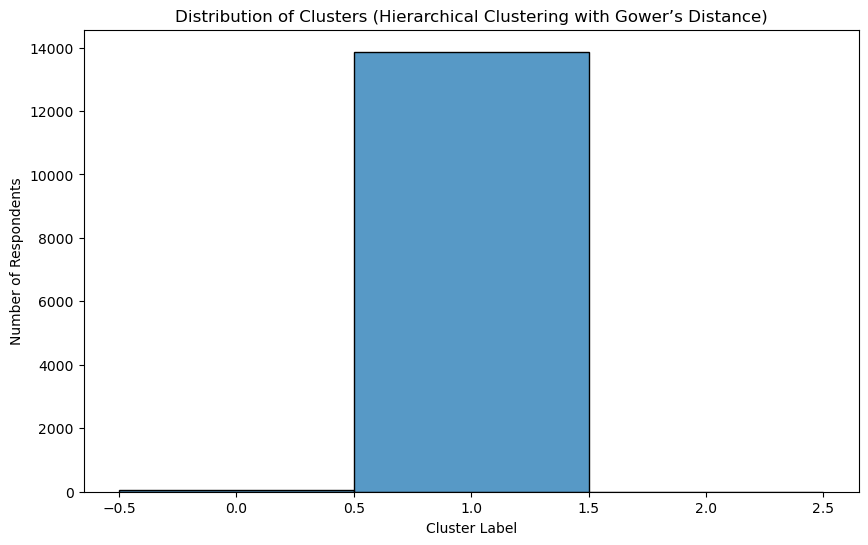

✅ Clustering Results Saved!


In [157]:
# ✅ Step 5: Apply Hierarchical Clustering (Agglomerative)
print("🚀 Applying Hierarchical Clustering...")

num_clusters = 3  # Adjust based on dendrogram
hac = AgglomerativeClustering(n_clusters=num_clusters, metric="precomputed", linkage="average")
df_g8["Cluster"] = hac.fit_predict(gower_dist)

print("✅ Clustering Completed. Cluster Counts:\n", df_g8["Cluster"].value_counts())

# ✅ Step 6: Visualizing Clusters
plt.figure(figsize=(10, 6))
sns.histplot(df_g8["Cluster"], bins=num_clusters, discrete=True)
plt.title("Distribution of Clusters (Hierarchical Clustering with Gower’s Distance)")
plt.xlabel("Cluster Label")
plt.ylabel("Number of Respondents")
plt.show()

# ✅ Save Clustered Data
df_g8.to_csv("data/preprocessed/clustered_rq4_gower.csv", index=False)
print("✅ Clustering Results Saved!")